In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from scipy.stats import zscore as zs
from scipy import linalg as scipy_linalg
from sklearn.model_selection import train_test_split as split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
from google.colab import files
from keras.optimizers import SGD
from IPython.display import display, Image


In [2]:

import matplotlib.ticker as ticker
from pylab import rcParams
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
plt.style.context('fivethirtyeight')

In [3]:

%%capture
!pip install tensorflow-gpu

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = '/content/drive/MyDrive/data/Data/COMBINED.csv'
oil_df = pd.read_csv(file_path)
oil_df.head(2)

,Unnamed: 0,Date,WTI,GOLD,SP 500,US DOLLAR INDEX,DJU,US 10YR BOND
0,0,04-01-2000,25.55,282.70,"1,411.75",100.10,278.510010,6.499
1,1,05-01-2000,24.91,281.10,"1,413.50",100.05,289.109985,6.599


In [6]:
oil_df=oil_df.drop(columns=['Unnamed: 0'])

oil_df.info

<bound method DataFrame.info of             Date    WTI      GOLD    SP 500  US DOLLAR INDEX         DJU  \
0     04-01-2000  25.55    282.70  1,411.75          100.100  278.510010   
1     05-01-2000  24.91    281.10  1,413.50          100.050  289.109985   
2     06-01-2000  24.78    281.40  1,404.00          100.340  292.640015   
3     07-01-2000  24.22    281.90  1,460.50          100.500  297.779999   
4     10-01-2000  24.67    281.70  1,475.00          100.650  296.369995   
...          ...    ...       ...       ...              ...         ...   
4859  04-06-2019  53.48  1,323.40  2,805.00           96.999  793.179993   
4860  05-06-2019  51.68  1,328.30  2,827.75           97.251  810.150024   
4861  06-06-2019  52.59  1,337.60  2,845.75           96.997  812.909973   
4862  07-06-2019  53.99  1,341.20  2,875.00           96.490  806.599976   
4863  10-06-2019  54.28  1,331.05  2,888.12           96.833  801.380005   

      US 10YR BOND  
0            6.499  
1            

In [7]:
oil_df.describe()

,WTI,US DOLLAR INDEX,DJU,US 10YR BOND
count,4864.000000,4864.000000,4864.000000,4864.000000
mean,62.135940,90.477981,458.967023,3.462449
std,26.559945,11.711035,147.436503,1.223185
min,17.450000,71.304000,167.570007,1.358000
25%,39.937500,80.923500,359.017510,2.388750
50%,59.495000,88.292500,437.494996,3.415000
75%,83.927500,96.940250,553.152496,4.429000
max,145.290000,121.210000,812.909973,6.790000


In [8]:
oil_df.isnull().sum()

Date               0
WTI                0
GOLD               0
SP 500             0
US DOLLAR INDEX    0
DJU                0
US 10YR BOND       0
dtype: int64

In [9]:
oil_df['Date'] = pd.to_datetime(oil_df['Date'],format='%d-%m-%Y')

In [10]:
oil_df.dtypes

Date               datetime64[ns]
WTI                       float64
GOLD                       object
SP 500                     object
US DOLLAR INDEX           float64
DJU                       float64
US 10YR BOND              float64
dtype: object

In [11]:
oil_df.set_index('Date',inplace=True)

In [12]:
oil_df.head(2)

,WTI,GOLD,SP 500,US DOLLAR INDEX,DJU,US 10YR BOND
Date,,,,,,
2000-01-04,25.55,282.70,"1,411.75",100.10,278.510010,6.499
2000-01-05,24.91,281.10,"1,413.50",100.05,289.109985,6.599


In [13]:
oil_df['SP 500'] = oil_df['SP 500'].str.replace(',', '').astype('float')
oil_df['GOLD'] =oil_df['GOLD'].str.replace(',', '').astype('float')

# Exploratory Data Analysis(EDA)

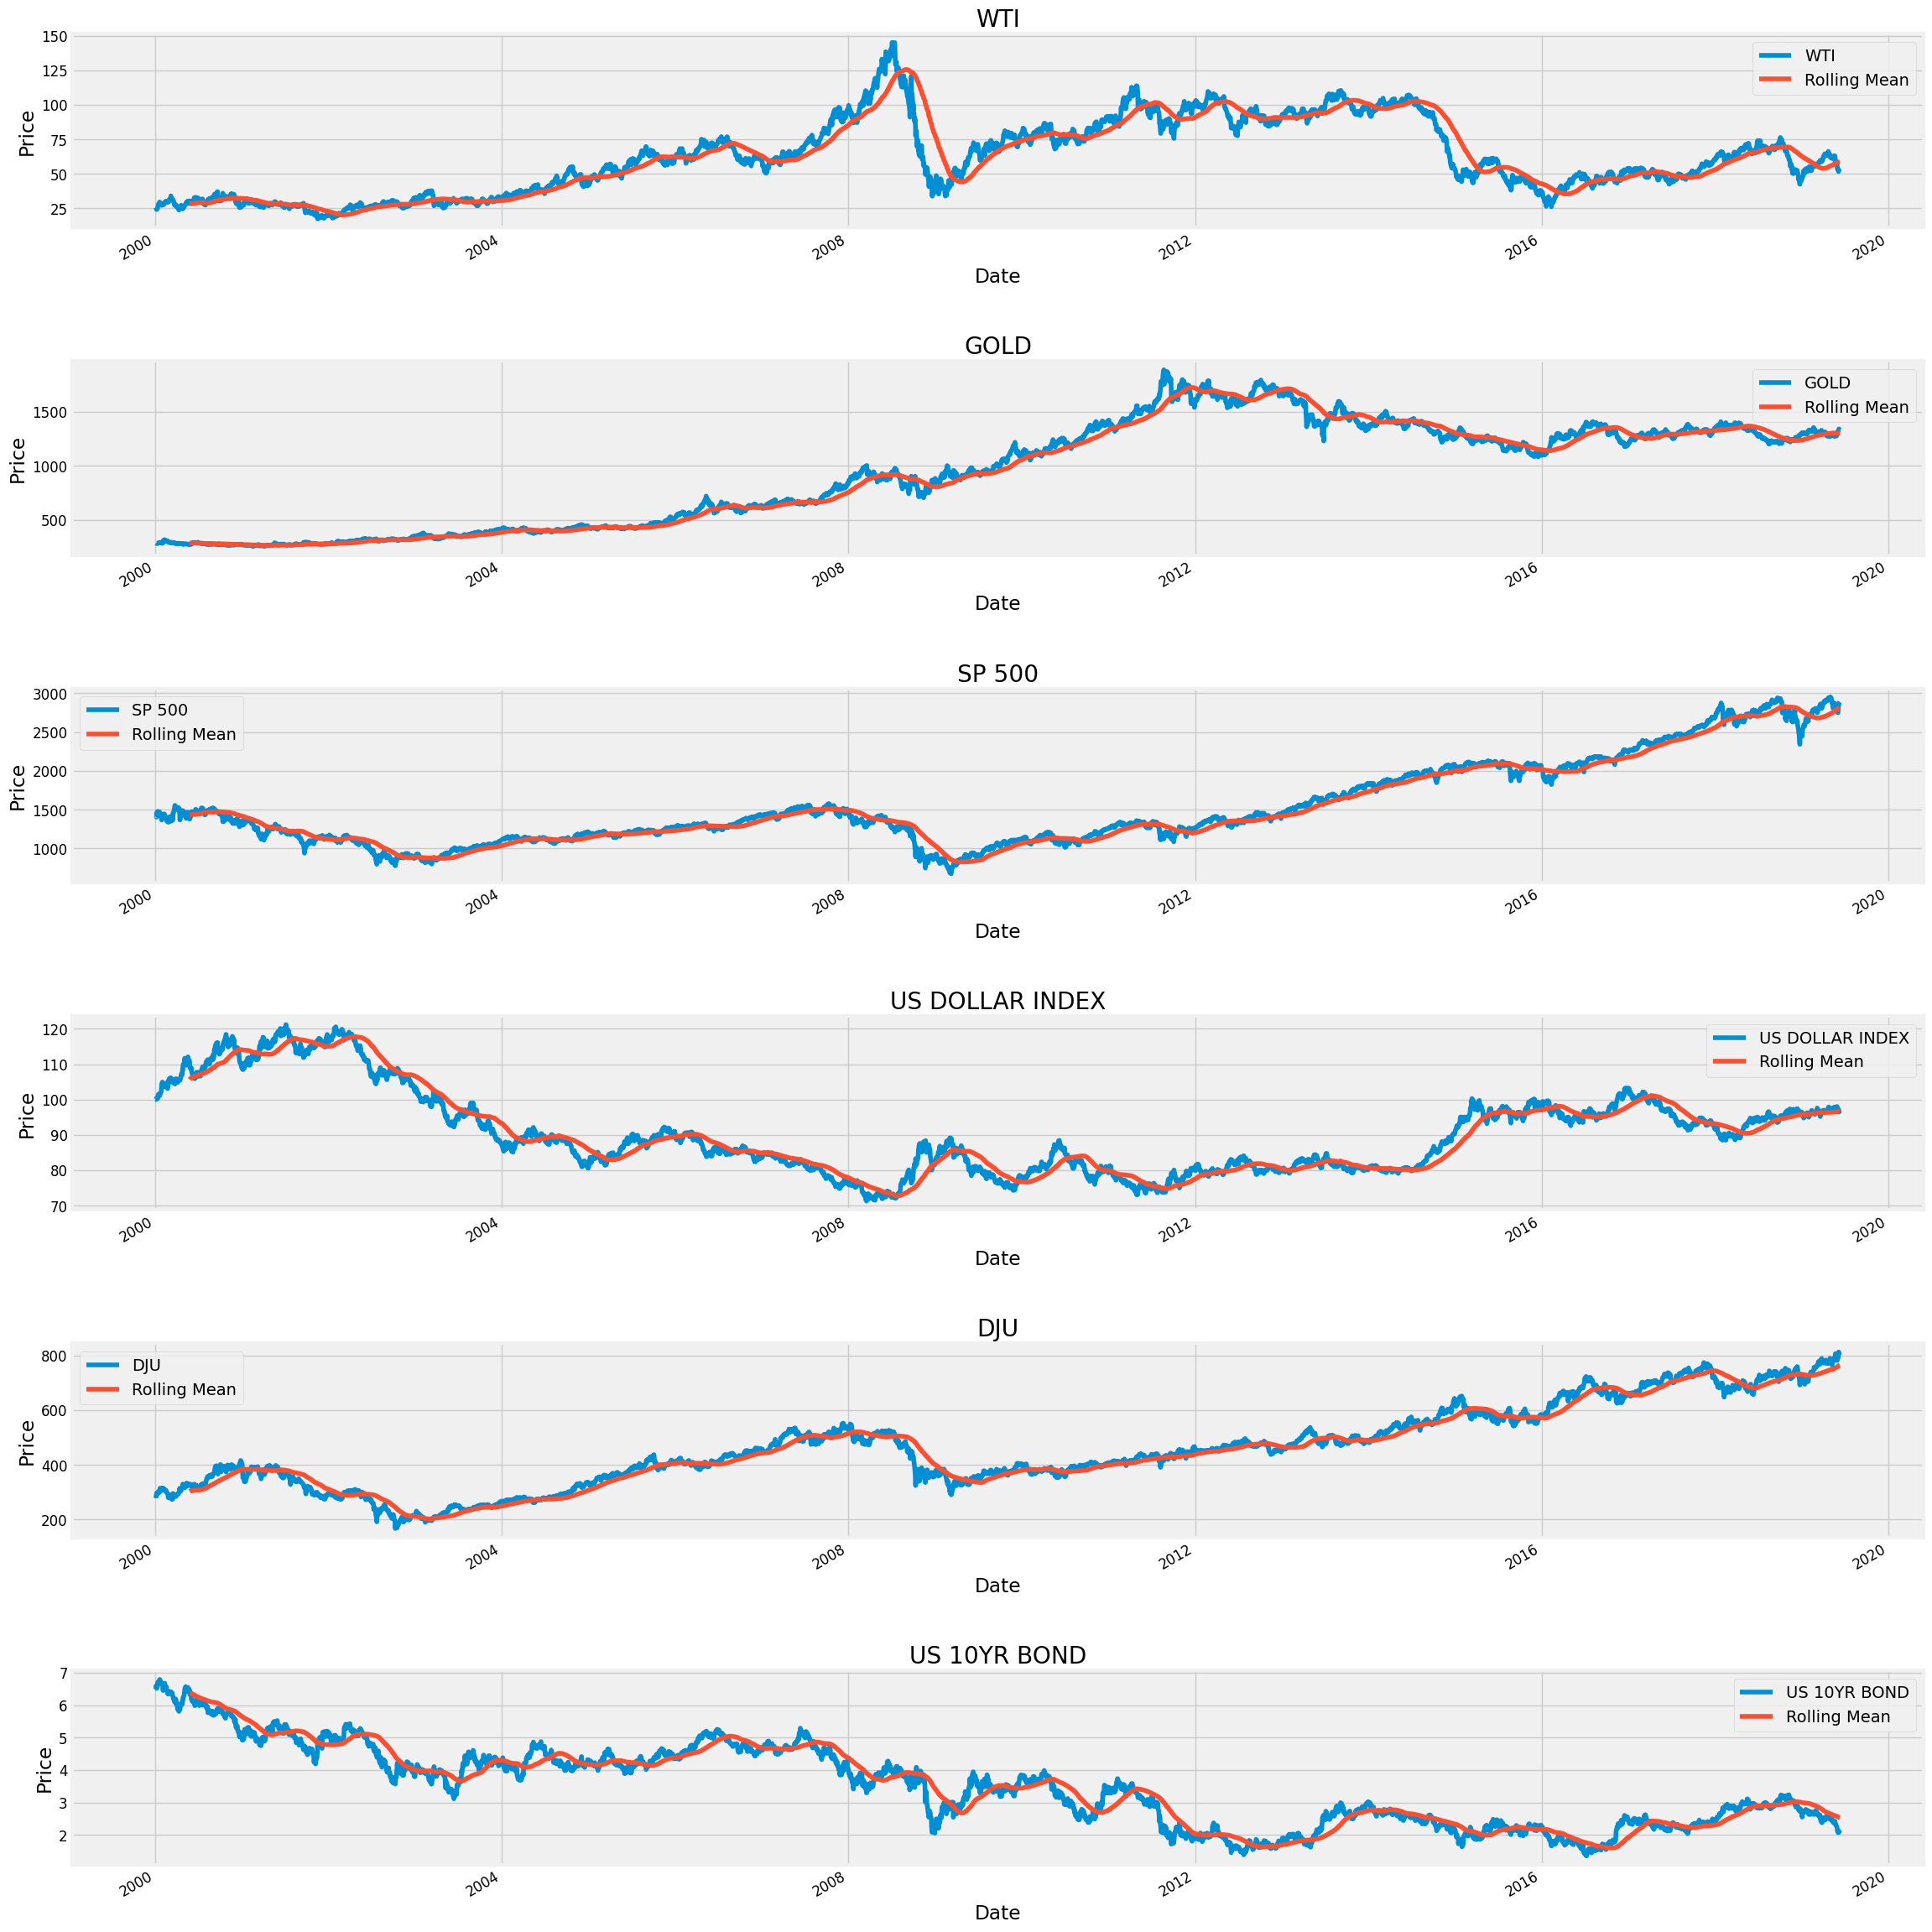

In [14]:

data = oil_df
col_names = data.columns

fig = plt.figure(figsize=(24, 24))
plt.style.use('fivethirtyeight')
for i in range(6):
  ax = fig.add_subplot(6,1,i+1)
  ax.plot(data.iloc[:,i],label=col_names[i])
  data.iloc[:,i].rolling(100).mean().plot(label='Rolling Mean')
  ax.set_title(col_names[i])
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  plt.legend()
fig.tight_layout(pad=3.0)
plt.show()

Inferences :-

-> WTI has mix of both UP and DOWN trends.

-> Gold, DJU has UP Trend.

-> US Dollar Index, US 10YR Bond has downward trend.


In [15]:
temp_data = oil_df
temp_data['Year'] = oil_df.index.year

Text(0.5, 1.0, 'Box Plot Year Wise-WTI')

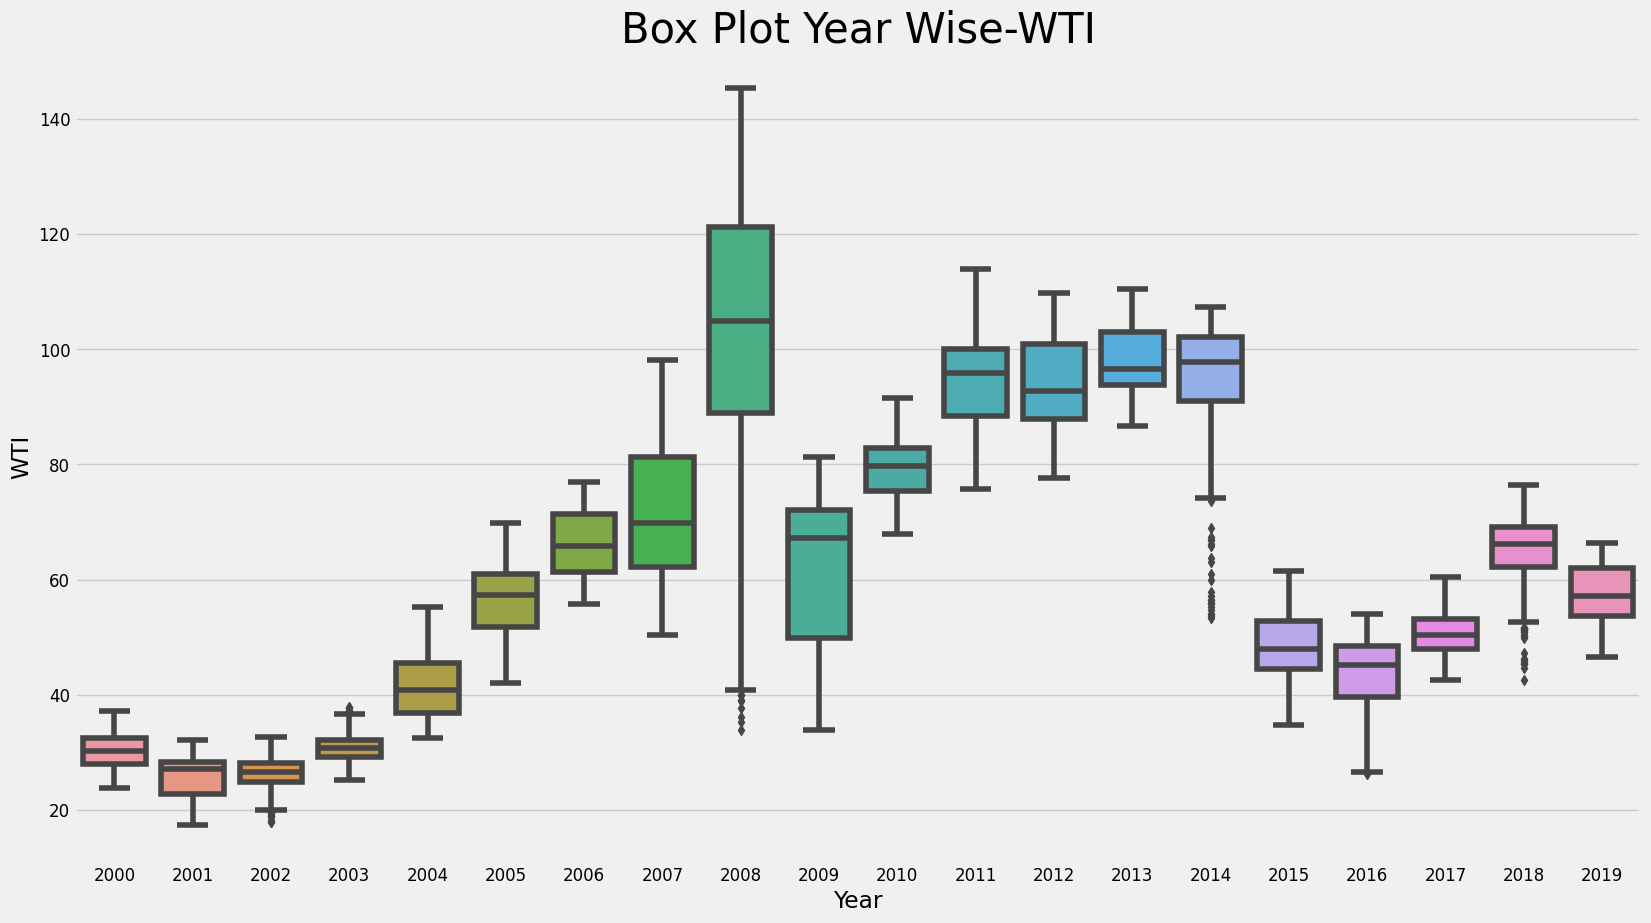

In [16]:
plt.figure(figsize=(18,10))
ax = sns.boxplot(x=temp_data['Year'], y=temp_data['WTI'])
ax.set_title('Box Plot Year Wise-WTI',fontsize=30)

-> During the years 2007, 2008, and 2009 wide variations in the values of WTI have been
observed. 

-> In the year 2008, which is the period of the financial crisis and huge volatality, the
WTI oil price varies between 30-140$.

-> Years 2002, 2008, 2014 & 2018 show outliers.


**Bivariate Analysis (WTI and Features)**

In [17]:
oil_df.drop(labels=['Year'],axis=1,inplace=True)

In [18]:

sc = MinMaxScaler(feature_range=(0,1))
oil_df_scaled= sc.fit_transform(oil_df)

In [19]:
oil_df_scaled[:2]

array([[0.06336045, 0.0168952 , 0.32376238, 0.57700477, 0.17190939,
        0.94642857],
       [0.05835419, 0.01591577, 0.32453245, 0.57600289, 0.18833481,
        0.964838  ]])

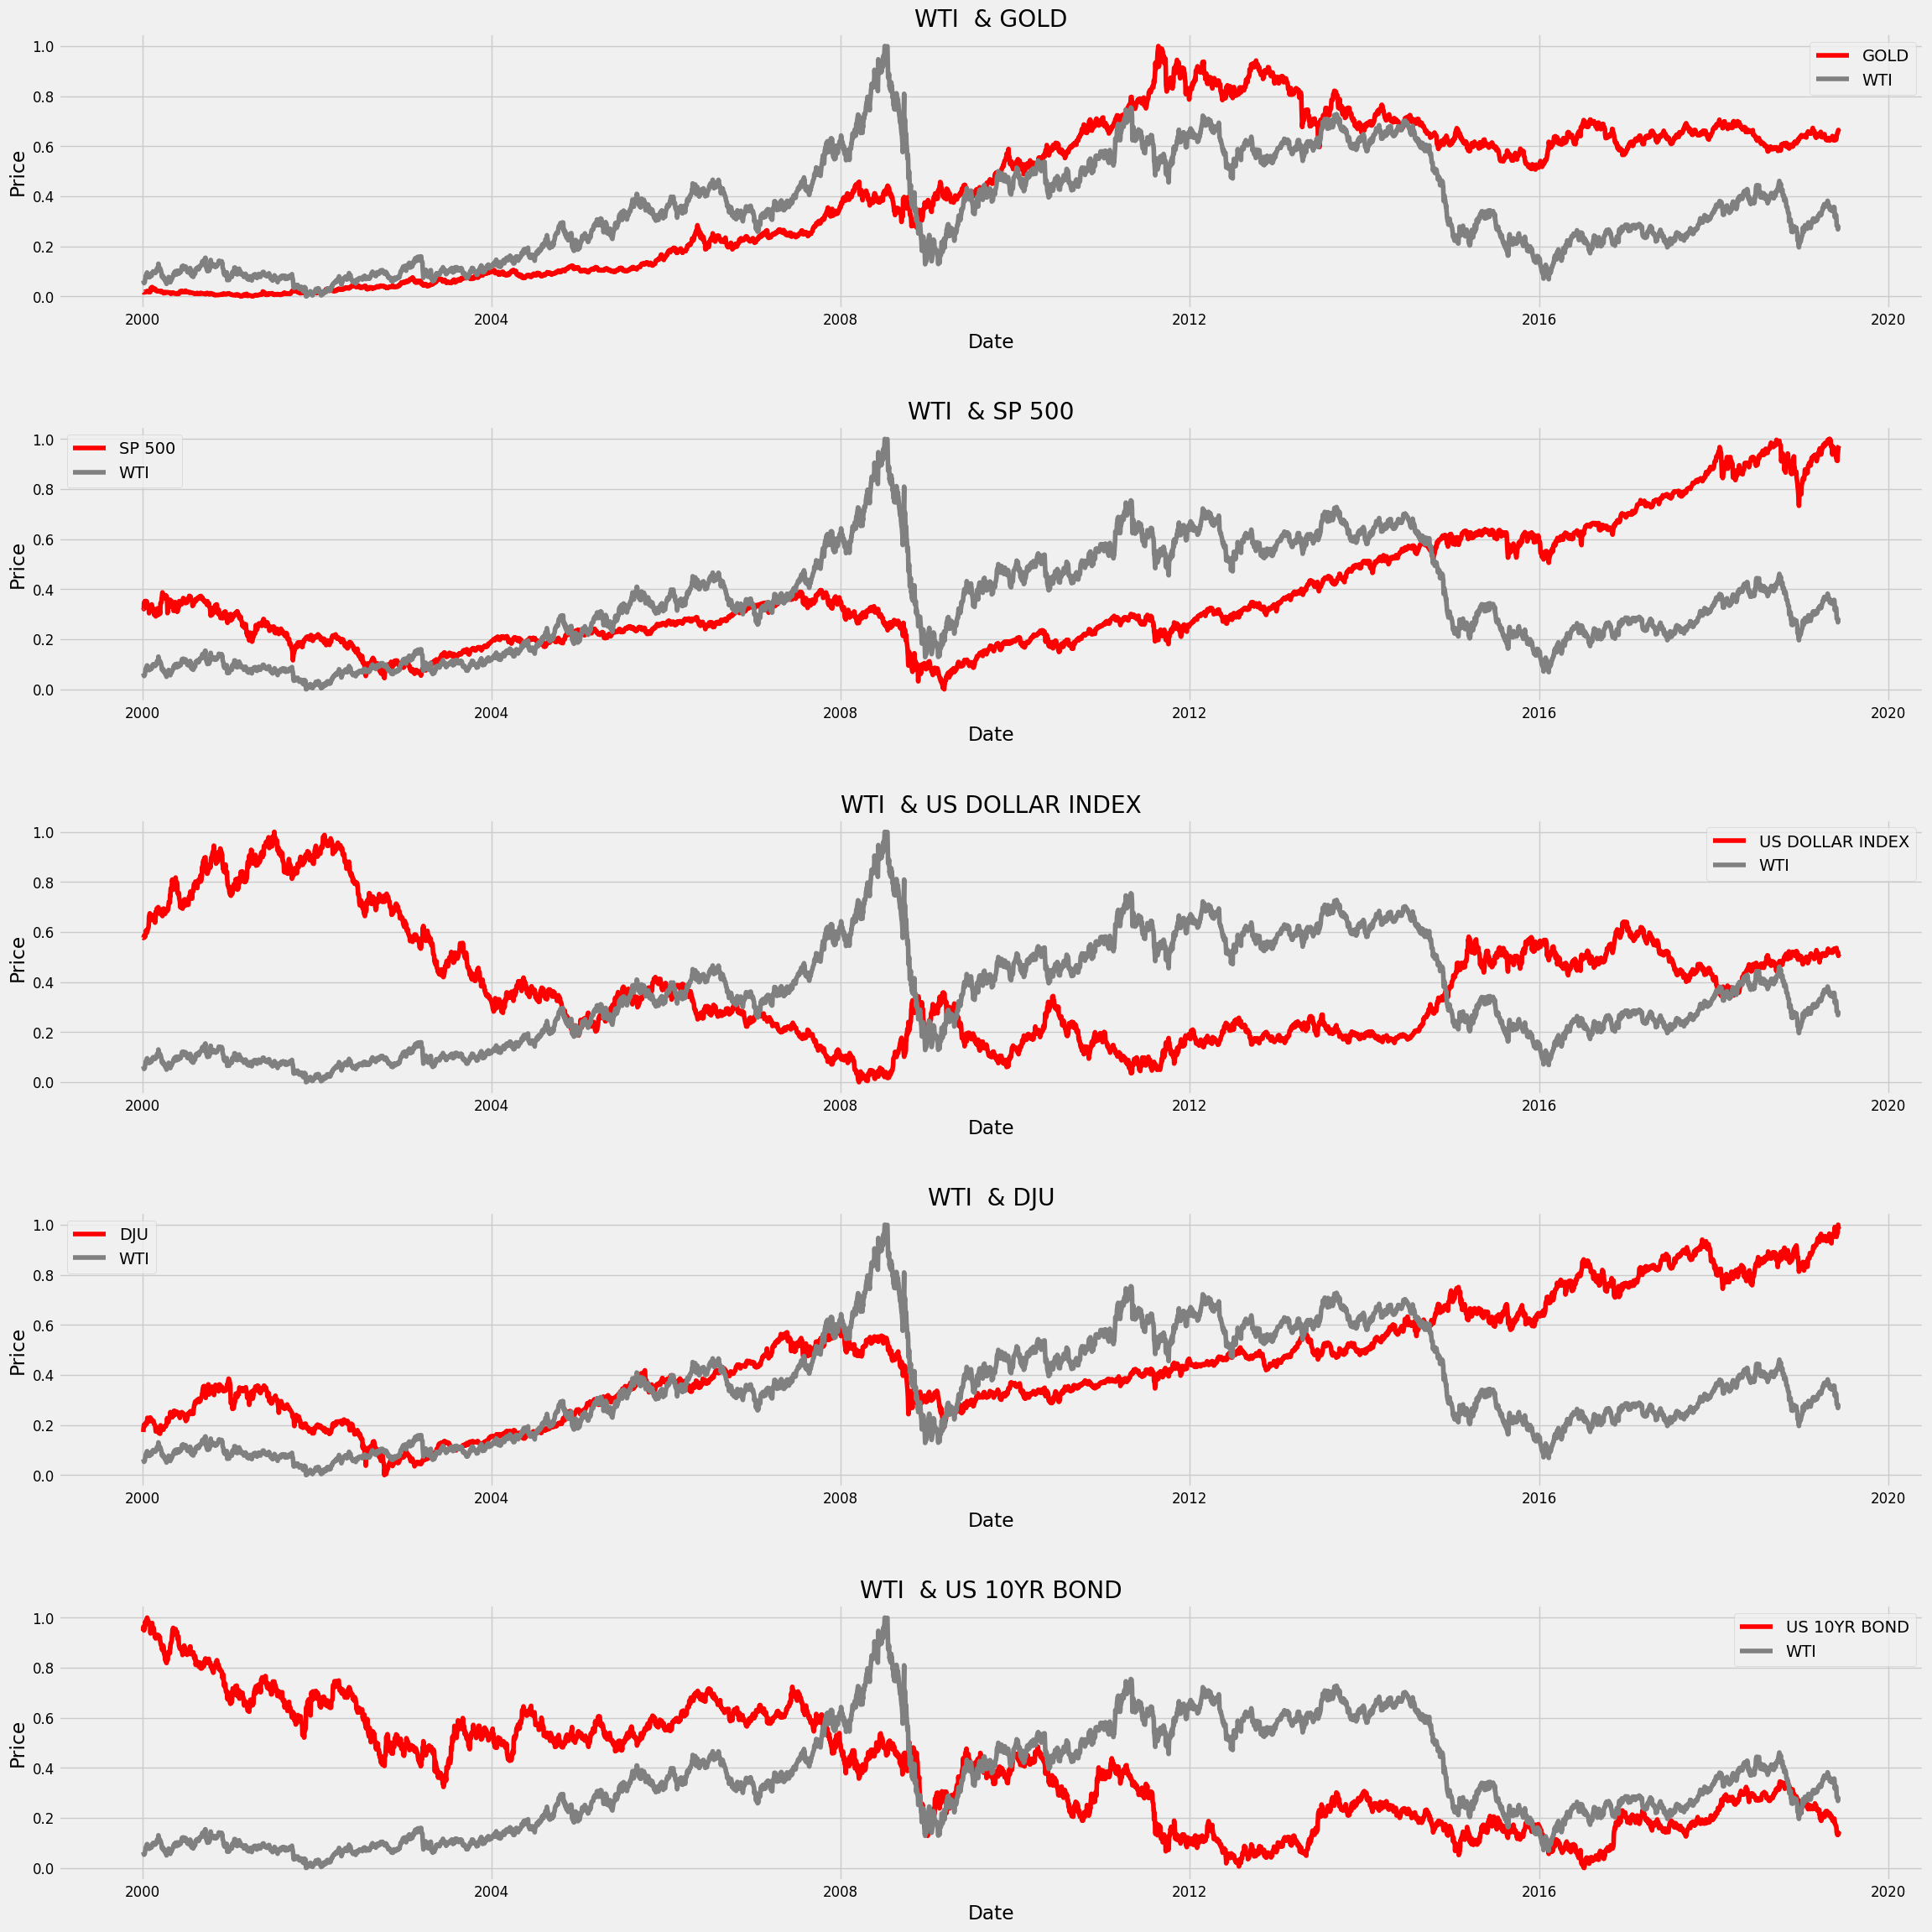

In [20]:
col_names = data.columns[1:]
scaled_features = oil_df_scaled[:,1:]
fig = plt.figure(figsize=(24, 24))
plt.style.use('fivethirtyeight')
for i in range(5):
  ax = fig.add_subplot(5,1,i+1)
  ax.plot(oil_df.index,scaled_features[:,i],label=col_names[i],c='red')
  ax.plot(oil_df.index,oil_df_scaled[:,0],label='WTI',c='grey')
  ax.set_title('WTI  & ' + col_names[i])
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  plt.legend()
fig.tight_layout(pad=3.0)
plt.show()

Inferences From Bivariate Feature Analysis :-

->During 2009 the value for both WTI and SP 500 drop sharply indicating that both these series are affected by same external factors. Move together.


->US Dollar index coinciding at several points
with WTI, meaning that both the variables are strongly correlated. Apart from some common
points the relationship seems to be inverse specifically when observing periods of 2000, 2007-
09 and 2010-16. Don't Move together.


->Both WTI and gold are fluctuating together.
The gold seems to be lagging to the WTI in some ways especially if we observe years 2007
wherein gold has not had much difference as WTI. Move together.

->US 10 year bond interest rates seem
to be a leading indicator to volatility of WTI price, as we can see specifically from 2000-09 US
bond progresses downward and then the WTI follows it. The US interest rate basically gave us
a leading indication to financial crisis is what we have observed. Don't Move together.

-> DJU & WTI move together.Very High correlation between 2003-2009.


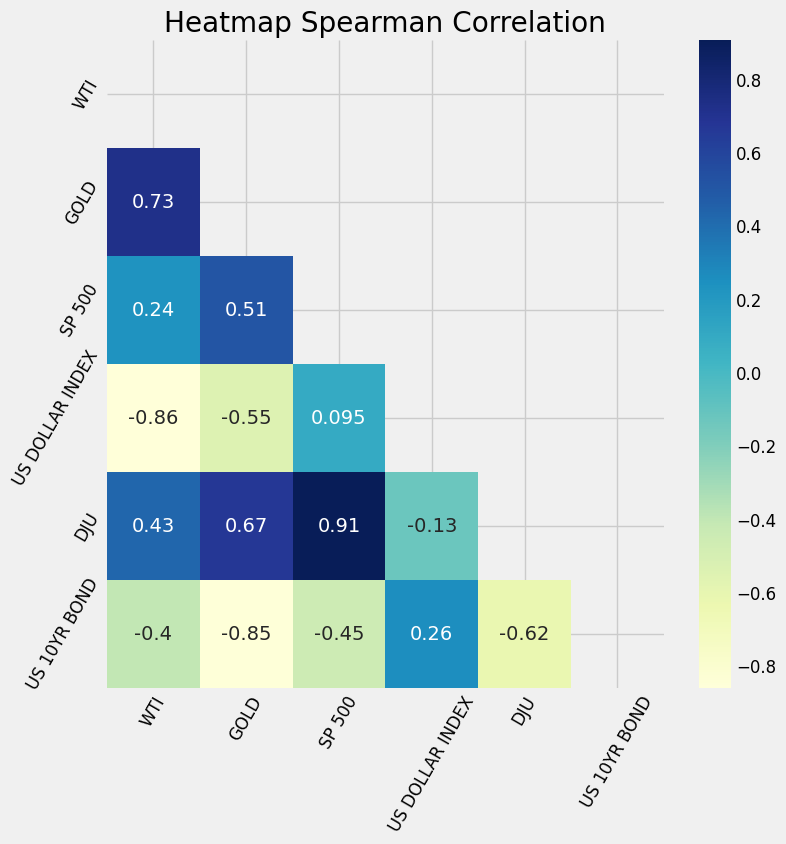

In [21]:
plt.figure(figsize=(8,8))
matrix = np.triu(oil_df.corr(method='spearman'))
heat_map = sns.heatmap(oil_df.corr(method='spearman'),annot=True,annot_kws={"size":14},cmap= 'YlGnBu',mask=matrix)
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=60)
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=60)
plt.tick_params(labelsize=12)
plt.title('Heatmap Spearman Correlation')
plt.style.use('fivethirtyeight')

-> The highest positive correlation with target variable WTI is with Gold(ρ:0.73)

-> We also observe that SP500 and WTI have less correlation.(ρ : 0.24)

-> US 10 YR Bond and WTI are moderately inversely correlated.(ρ : -0.4) 

-> DJU & WTI positive moderate correlation.(ρ : 0.43 )

-> US Dollar Index & WTI have high correlation .(ρ : -0.86)

-> We observe high correlation between DJU & SP 500 (ρ : 0.91)
observed the SP 500 and DJU also have very high positive correlation. Both are indexes


In [22]:
oil_df.corr(method='spearman')

,WTI,GOLD,SP 500,US DOLLAR INDEX,DJU,US 10YR BOND
WTI,1.000000,0.725931,0.236478,-0.860641,0.425457,-0.399341
GOLD,0.725931,1.000000,0.511883,-0.545670,0.672326,-0.849029
SP 500,0.236478,0.511883,1.000000,0.095491,0.907640,-0.451286
US DOLLAR INDEX,-0.860641,-0.545670,0.095491,1.000000,-0.125481,0.255396
DJU,0.425457,0.672326,0.907640,-0.125481,1.000000,-0.622686
US 10YR BOND,-0.399341,-0.849029,-0.451286,0.255396,-0.622686,1.000000


# Feature Selection

We eliminate all features having spearman correlation less than magnitude of 
0.4.  



In [23]:
after_fs = oil_df[['WTI','GOLD','US DOLLAR INDEX']]
after_fs.head(3)

,WTI,GOLD,US DOLLAR INDEX
Date,,,
2000-01-04,25.55,282.7,100.10
2000-01-05,24.91,281.1,100.05
2000-01-06,24.78,281.4,100.34


# **Outlier Elimination**

Financial Crisis Outlier Removal (2007-2009)**

In [24]:
before_2007 = after_fs['2000-01':'2007-06']
after_2009 = after_fs['2009-06':'2019-06']
fin_out = pd.concat([before_2007,after_2009],axis=0)
fin_out.shape

(4383, 3)

# Data Preparation for Modelling 

In [25]:
fin_train,fin_test = split(fin_out,train_size=0.7,shuffle=False)
van_train,van_test = split(after_fs,train_size=0.7,shuffle=False)

In [26]:
print('Fin Outlier Dataset')
print(fin_train.shape)
print(fin_test.shape)

Fin Outlier Dataset
(3068, 3)
(1315, 3)


In [27]:
sc1 = MinMaxScaler(feature_range=(0,1))
sc2 = MinMaxScaler(feature_range=(0,1))

In [28]:
def prepare_train_data_lstm(scaler,train_data,n_dim):
  input_data = scaler.fit_transform(train_data.values)
  print('Shape of Input Data Initially',input_data.shape)
  timesteps = 60
  global X1
  X1 = []
  global y1
  y1=[]
  for i in range(len(input_data)-timesteps-1):
    t=[]
    for j in range(0,timesteps):        
      
        t.append(input_data[[(i+j)], :])
    X1.append(t)
    y1.append(input_data[i+ timesteps,0])
  
  X1, y1= np.array(X1), np.array(y1)
  print('Shape of Train Part after transformation',X1.shape)
  print('Shape of Test Part after transformation ',y1.shape)
  
  X1 = X1.reshape(X1.shape[0],timesteps, n_dim)
  print('Final Shape ',X1.shape)
  return X1,y1

In [29]:

def lstm_model(scaler,train_data,n_dim):

  prepare_train_data_lstm(scaler,train_data,n_dim)

  global model
  model = Sequential()
 

  model.add(LSTM(units=30,return_sequences=True,input_shape=(X1.shape[1],n_dim)))
  model.add(Dropout(0.2))
 

  model.add(LSTM(units=30,return_sequences=True))
  model.add(Dropout(0.2))
 

  model.add(LSTM(units=30,return_sequences=True))
  model.add(Dropout(0.2))
 

  model.add(LSTM(units=30))
  model.add(Dropout(0.2))
 

  model.add(Dense(units=1))

  optimizer = tf.keras.optimizers.Adam(lr=2e-5)

  model.compile(optimizer=optimizer,loss='mean_squared_error')
  model.fit(X1, y1, epochs=50, batch_size=32)

In [30]:
def prepare_test_data_lstm(scaler,test_data,n_dim):
  inputs = scaler.transform(test_data.values)
  global X_test
  X_test = []
  timesteps = 60
  for i in range(len(inputs)-timesteps-1):
      t=[]
      for j in range(0,timesteps):
        
          t.append(inputs[[(i+j)], :])
      X_test.append(t)
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_dim))
  print('Shape of Test Dataset',X_test.shape)

In [31]:
def predict_data(model_name,scaler_pred,test_data,X_test,Outlier_method,n_dim):
  
  pred = model_name.predict(X_test)
  print(len(test_data[61:]))
  set_scale = scaler_pred.fit_transform(test_data.iloc[61:,0].values.reshape(-1,1))
  pred_descale = scaler_pred.inverse_transform(pred)
  global pred_df
  pred_df = pd.DataFrame(pred_descale,columns=['Predicted -'+str(Outlier_method)])
  return pred_df

In [32]:
def result_metrics_forecast(test_series,forecast_series,model_name,out_name):
  print('Result Metrics for ' +  str(model_name) + ' -{} Outlier Removal Technique'.format(out_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))
  fig = plt.figure(figsize=(10,10))
  plt.plot(test_series.index,test_series,label='Actual')
  plt.plot(test_series.index,forecast_series,label='Predicted')
  plt.title(str(model_name) + ' -Forecasting Using {} Outlier Removal Technique'.format(out_name))
  plt.ylabel('Price')
  plt.legend()

# Hyper-parameter Tuning Learning Rate 

In [33]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'loss',patience = 20)
X1,y1 = prepare_train_data_lstm(sc1,fin_train,3)

Shape of Input Data Initially (3068, 3)
Shape of Train Part after transformation (3007, 60, 1, 3)
Shape of Test Part after transformation  (3007,)
Final Shape  (3007, 60, 3)


In [34]:
import tensorflow as tf


model_simple = Sequential()
 

model_simple.add(LSTM(units=64,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))


model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))


model_simple.add(LSTM(units=16,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))


model_simple.add(Dense(units=16))

model_simple.add(Dense(units=1))



lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.Adam(lr=1e-8)
model_simple.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])


history_simple = model_simple.fit(X1, y1, epochs=200, batch_size=32,callbacks=[lr_schedule],validation_split=0.3,shuffle=False)

Epoch 1/200
66/66 [==============================] - 15s 36ms/step - loss: 0.0647 - mae: 0.3087 - val_loss: 0.2749 - val_mae: 0.7362 - lr: 1.0000e-08
Epoch 2/200
66/66 [==============================] - 1s 18ms/step - loss: 0.0648 - mae: 0.3091 - val_loss: 0.2749 - val_mae: 0.7361 - lr: 1.2589e-08
Epoch 3/200
66/66 [==============================] - 1s 19ms/step - loss: 0.0646 - mae: 0.3084 - val_loss: 0.2748 - val_mae: 0.7360 - lr: 1.5849e-08
Epoch 4/200
66/66 [==============================] - 1s 20ms/step - loss: 0.0645 - mae: 0.3088 - val_loss: 0.2747 - val_mae: 0.7358 - lr: 1.9953e-08
Epoch 5/200
66/66 [==============================] - 1s 23ms/step - loss: 0.0647 - mae: 0.3083 - val_loss: 0.2746 - val_mae: 0.7357 - lr: 2.5119e-08
Epoch 6/200
66/66 [==============================] - 1s 22ms/step - loss: 0.0645 - mae: 0.3086 - val_loss: 0.2744 - val_mae: 0.7355 - lr: 3.1623e-08
Epoch 7/200
66/66 [==============================] - 1s 16ms/step - loss: 0.0645 - mae: 0.3080 - val_loss

Text(0.5, 1.0, 'Learning Rate vs Loss')

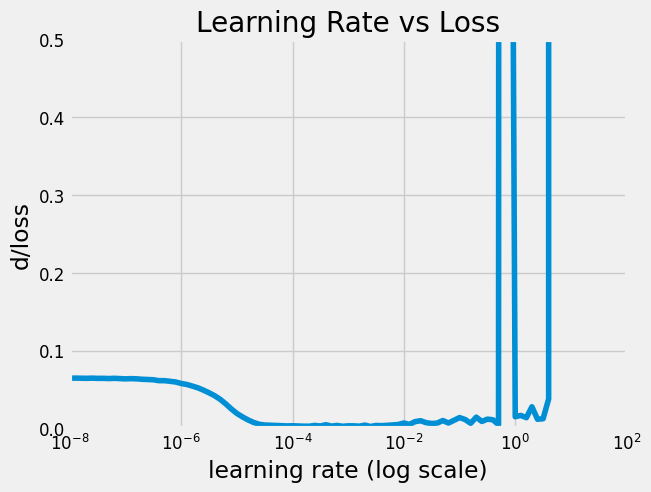

In [35]:
plt.semilogx(history_simple.history["lr"], history_simple.history["loss"])
plt.axis([1e-8, 100, 0, 60])
plt.ylim(0,0.5)
plt.ylabel("d/loss")
plt.xlabel("learning rate (log scale)")
plt.title('Learning Rate vs Loss')

In [37]:

model_simple = Sequential()

model_simple.add(LSTM(units=64,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))


model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))


model_simple.add(LSTM(units=16,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

 
model_simple.add(Dense(units=16))

model_simple.add(Dense(units=1))



optimizer = tf.keras.optimizers.Adam(lr=3e-5)
model_simple.compile(loss=tf.keras.losses.MSE,
              optimizer=optimizer)

history_simple = model_simple.fit(X1, y1, epochs=40, batch_size=32,validation_split=0.3,shuffle=False)

Epoch 1/40
66/66 [==============================] - 9s 35ms/step - loss: 0.0082 - val_loss: 0.0093
Epoch 2/40
66/66 [==============================] - 1s 20ms/step - loss: 0.0139 - val_loss: 0.0113
Epoch 3/40
66/66 [==============================] - 1s 22ms/step - loss: 0.0219 - val_loss: 0.0357
Epoch 4/40
66/66 [==============================] - 1s 19ms/step - loss: 0.0245 - val_loss: 0.0199
Epoch 5/40
66/66 [==============================] - 1s 15ms/step - loss: 0.0230 - val_loss: 0.0222
Epoch 6/40
66/66 [==============================] - 1s 15ms/step - loss: 0.0097 - val_loss: 0.0237
Epoch 7/40
66/66 [==============================] - 1s 15ms/step - loss: 0.0109 - val_loss: 0.0208
Epoch 8/40
66/66 [==============================] - 1s 15ms/step - loss: 0.0101 - val_loss: 0.0135
Epoch 9/40
66/66 [==============================] - 1s 16ms/step - loss: 0.0044 - val_loss: 0.0106
Epoch 10/40
66/66 [==============================] - 1s 15ms/step - loss: 0.0040 - val_loss: 0.0118
Epoch 11/

In [39]:
lstm_model(sc1,fin_train,3)

Shape of Input Data Initially (3068, 3)
Shape of Train Part after transformation (3007, 60, 1, 3)
Shape of Test Part after transformation  (3007,)
Final Shape  (3007, 60, 3)


Epoch 1/50
94/94 [==============================] - 8s 16ms/step - loss: 0.0296
Epoch 2/50
94/94 [==============================] - 2s 19ms/step - loss: 0.0063
Epoch 3/50
94/94 [==============================] - 1s 16ms/step - loss: 0.0053
Epoch 4/50
94/94 [==============================] - 1s 13ms/step - loss: 0.0050
Epoch 5/50
94/94 [==============================] - 1s 13ms/step - loss: 0.0048
Epoch 6/50
94/94 [==============================] - 1s 13ms/step - loss: 0.0042
Epoch 7/50
94/94 [==============================] - 1s 13ms/step - loss: 0.0042
Epoch 8/50
94/94 [==============================] - 1s 13ms/step - loss: 0.0039
Epoch 9/50
94/94 [==============================] - 2s 21ms/step - loss: 0.0038
Epoch 10/50
94/94 [==============================] - 1s 13ms/step - loss: 0.0039
Epoch 11/50
94/94 [==============================] - 2s 18ms/step - loss: 0.0037
Epoch 12/50
94/94 [==============================] - 2s 24ms/step - loss: 0.0033
Epoch 13/50
94/94 [==================

In [40]:
prepare_test_data_lstm(sc1,fin_test,3)

Shape of Test Dataset (1254, 60, 3)


In [41]:
predict_data(model,sc2,fin_test,X_test,'Financial Outlier',3)

40/40 [==============================] - 1s 6ms/step
1254


,Predicted -Financial Outlier
0,97.478981
1,98.047211
2,98.638550
3,99.111969
4,99.373482
...,...
1249,60.627895
1250,59.742508
1251,58.797714
1252,57.835438


In [42]:
fin_out_pred = pred_df.copy()
fin_out_actual = fin_test.iloc[61:,0].copy()

Result Metrics for LSTM -Financial Outlier Removal Technique
R2 Score :  0.931
Mean Squared Error :  15.562
Mean Absolute Error :  3.142


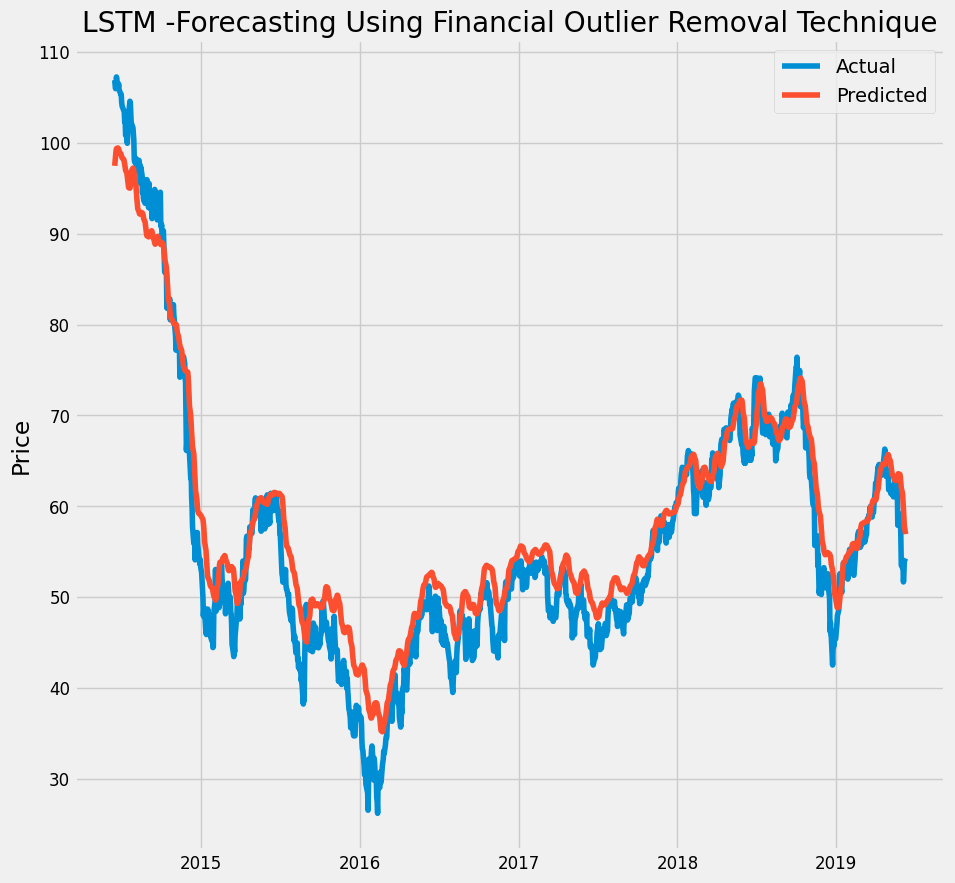

In [43]:
result_metrics_forecast(fin_out_actual,fin_out_pred,'LSTM','Financial')

In [44]:
lstm_model(sc1,van_train,3)

Shape of Input Data Initially (3404, 3)
Shape of Train Part after transformation (3343, 60, 1, 3)
Shape of Test Part after transformation  (3343,)
Final Shape  (3343, 60, 3)


Epoch 1/50
105/105 [==============================] - 8s 13ms/step - loss: 0.0134
Epoch 2/50
105/105 [==============================] - 1s 13ms/step - loss: 0.0042
Epoch 3/50
105/105 [==============================] - 1s 13ms/step - loss: 0.0036
Epoch 4/50
105/105 [==============================] - 2s 14ms/step - loss: 0.0030
Epoch 5/50
105/105 [==============================] - 2s 18ms/step - loss: 0.0030
Epoch 6/50
105/105 [==============================] - 2s 15ms/step - loss: 0.0028
Epoch 7/50
105/105 [==============================] - 1s 13ms/step - loss: 0.0026
Epoch 8/50
105/105 [==============================] - 1s 13ms/step - loss: 0.0025
Epoch 9/50
105/105 [==============================] - 1s 13ms/step - loss: 0.0025
Epoch 10/50
105/105 [==============================] - 1s 13ms/step - loss: 0.0020
Epoch 11/50
105/105 [==============================] - 1s 13ms/step - loss: 0.0020
Epoch 12/50
105/105 [==============================] - 1s 13ms/step - loss: 0.0021
Epoch 13/50
1

In [45]:
prepare_test_data_lstm(sc1,van_test,3)

Shape of Test Dataset (1399, 60, 3)


In [46]:
predict_data(model,sc2,van_test,X_test,'Vanilla Model',3)

44/44 [==============================] - 1s 6ms/step
1399


,Predicted -Vanilla Model
0,76.326790
1,76.352615
2,76.301277
3,76.202965
4,76.043396
...,...
1394,53.363934
1395,52.627266
1396,51.885254
1397,51.172379


In [47]:
van_pred = pred_df.copy()
van_actual = van_test.iloc[61:,0].copy()

Result Metrics for LSTM -Vanilla Model-No Outlier Removal Technique
R2 Score :  0.766
Mean Squared Error :  88.126
Mean Absolute Error :  6.63


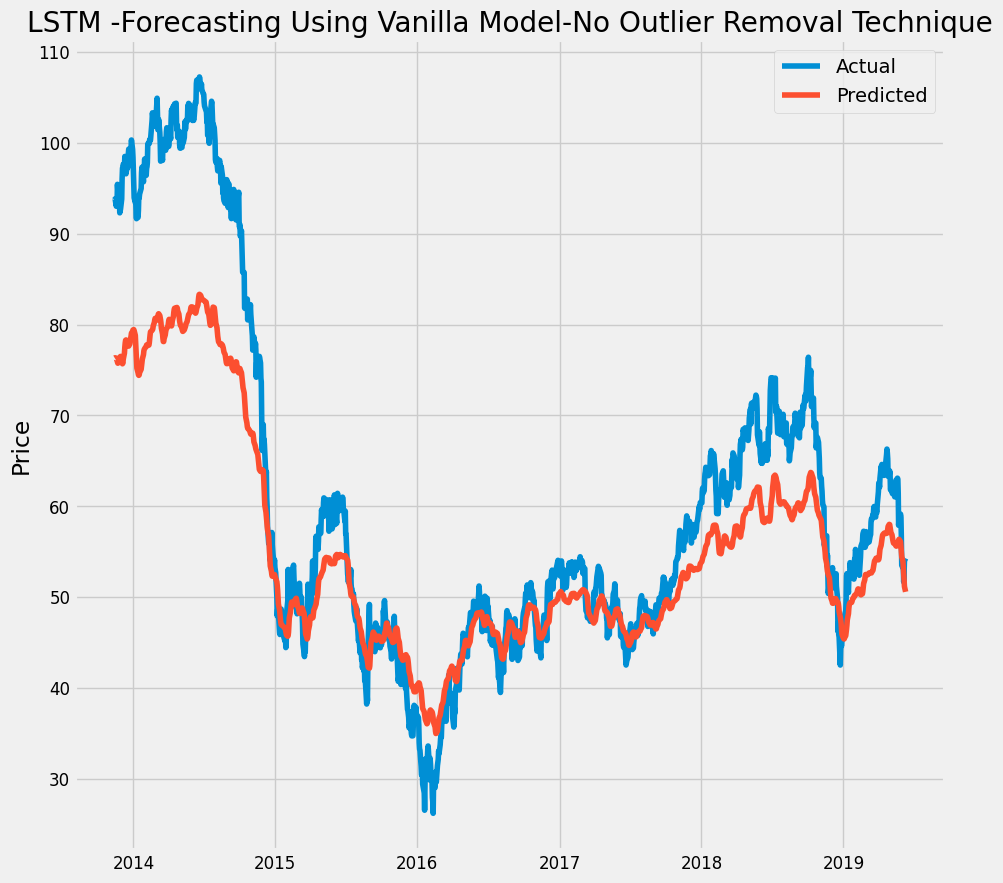

In [48]:
result_metrics_forecast(van_actual,van_pred,'LSTM','Vanilla Model-No')

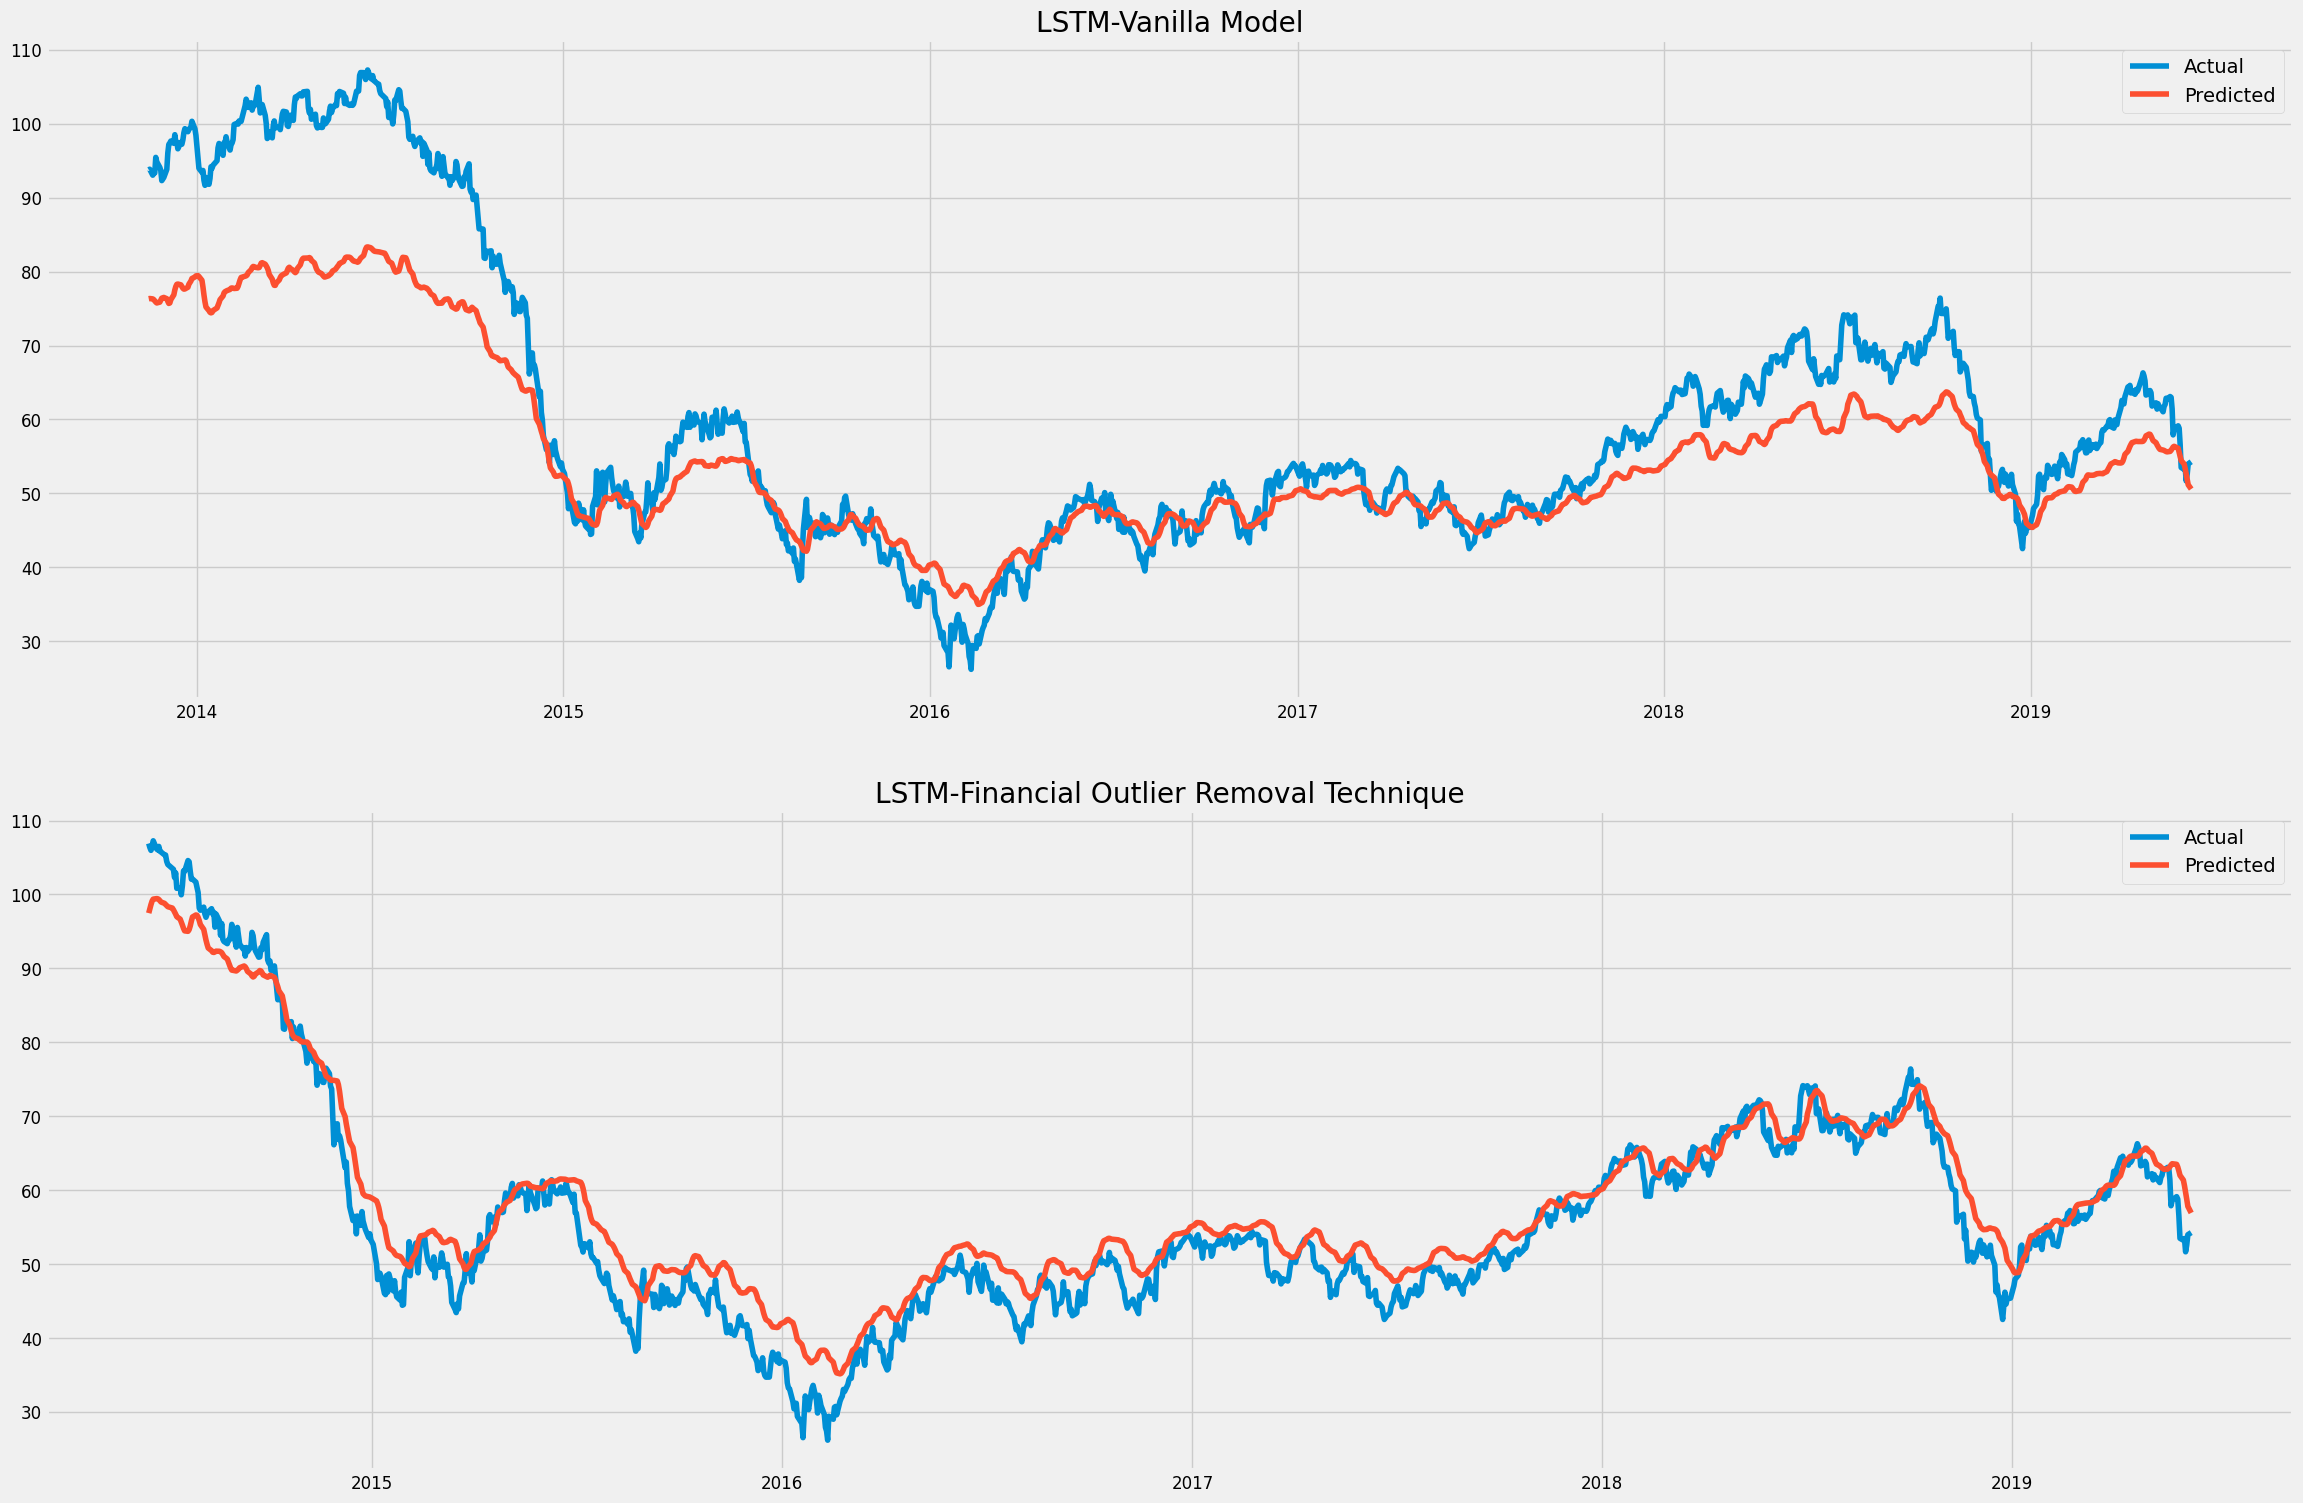

In [49]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(24,16))

ax1.plot(van_actual.index,van_actual,label='Actual')
ax1.plot(van_actual.index,van_pred,label='Predicted')
plt.title('Forecasting-No Outlier Removal Technique')
ax1.set_title('LSTM-Vanilla Model')

ax2.plot(fin_out_actual.index,fin_out_actual,label='Actual')
ax2.plot(fin_out_actual.index,fin_out_pred,label='Predicted')
ax2.set_title('LSTM-Financial Outlier Removal Technique')



ax1.legend()
ax2.legend()


plt.tight_layout(pad=3)

In [50]:
fin_out_pred

,Predicted -Financial Outlier
0,97.478981
1,98.047211
2,98.638550
3,99.111969
4,99.373482
...,...
1249,60.627895
1250,59.742508
1251,58.797714
1252,57.835438
